# word2vec

- 통계 기반 기법의 문제점
  - SVD를 사용하여 차원축소를 했었는데, nxn 행렬에 SVD를 적용하는 비용으ㄴ $O(n^3)$으로 너무 큼.
- 추론 기반 기법
  - neural network가 미니배치로 학습 데이터를 소량씩 나눠서 학습하듯이 추론 기반 기법도 학습 데이터 일부를 순차적으로 학습
  <br/> <img src='../figs/fig%203-1.png'>


### 추론 기반 기법 개요
- 추론 기반 기법은 주변 단어(맥락)이 주어졌을때 무슨 단어가 들어갈지 추측하는 작업.
<br/> <img src='../figs/fig%203-2.png'>

### 신경망에서의 단어 처리
- 신경망을 이용하기 위해 '단어'를 '고정 길이의 벡터'로 변환해야 함.
- One-hot 벡터로 변환
 

In [1]:
import numpy as np
# ID가 0인 벡터를 one-hot 벡터로 표현한 후 fully-conn'd layer를 통과시켜 변환하는 모습
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)        

[[-0.61148956  0.68061754  0.90728812]]


- 위 식에서 c와 W의 곱은 가중치 W의 row 벡터 하나를 뽑아낸 것과 같음
- 벡터와 행렬을 곱하지 않아도 row 벡터 추출 가능. -> 계산량 감소

In [2]:
# 우리가 구현한 MatMul을 통해 표현하는 방법
import sys
sys.path.append('..')
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[0.91049673 2.19936276 0.00370794]]


## CBOW(Continuous Bag-Of-Words)
- CBOW 모델은 맥락으로부터 target을 추측하는 용도의 신경망.
- input : 맥락, 맥락을 one-hot encoding
- CBOW 구조
<br/> <img src='../figs/fig%203-9.png' width ='300px'>
- 입력시킬 단어의 개수만큼 입력층이 존재.
- hidden layer에서는 input layer들의 평균값 계산
- 출력 시 softmax를 통해 확률 얻음

In [3]:
# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# layer 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# forward propagation
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[ 0.59653483  1.63914443 -0.05488032 -0.11127409  2.33992366  0.62294301
   0.69837282]]


### 학습
- CBOW 모델은 학습시 사용한 말뭉치(corpus)에 따라 얻게 되는 단어의 분산 표현이 다름.
<br/> <img src='../figs/fig%203-13.png'>
- Softmax로 해당 단어가 해당 자리에 나타날 확률을 구한 후 Cross-entropy Error를 통해 Loss 계산, 학습

### 가중치
- CBOW 모델에서 사용되는 신경망에는 가중치가 2개 존재 : W_in, W_out
- W_in의 각 행이 각 단어의 분산표현임.
- W_out에도 단어의 가중치가 저장됨
<br/> <img src='../figs/fig%203-15.png'>
- word2vec에서는 보통 W_in만 사용함(특히 skip-gram)
- GloVE에서는 두 가중치를 더해서 사용했을때 좋은 결과를 얻었음

In [4]:
from common.util import preprocess
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [5]:
print(corpus)

[0 1 2 3 4 1 5 6]


In [6]:
# 맥락(context)과 타깃(target)을 구하는 함수 구현
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for i in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[i + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

In [7]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [8]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [9]:
def convert_one_hot(corpus, vocab_size):
    '''
    corpus를 one-hot vector로 변환
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [10]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [11]:
import sys
sys.path.append('..')
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # initialize weight
        W_in = 0.01 * np.random.randn(V, H).astype('f') 
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # layer 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        #list에 모으기
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 단어의 분산표현 저장
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

## 학습

In [12]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

In [13]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

#Create context, target
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)

# one-hot encoding
contexts = convert_one_hot(contexts, vocab_size)
target = convert_one_hot(target, vocab_size)

#model 선언
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [14]:
contexts.shape

(6, 2, 7)

| epoch 1 |  itr 1/2 | time 0.004987478256225586[s] | loss 1.9458025489871886
| epoch 101 |  itr 1/2 | time 0.047454833984375[s] | loss 1.7057571780875636
| epoch 201 |  itr 1/2 | time 0.11926531791687012[s] | loss 1.235760001576468
| epoch 301 |  itr 1/2 | time 0.1581254005432129[s] | loss 0.9484550981613402
| epoch 401 |  itr 1/2 | time 0.1960616111755371[s] | loss 0.8603611637992985
| epoch 501 |  itr 1/2 | time 0.23595499992370605[s] | loss 0.6282781508083841
| epoch 601 |  itr 1/2 | time 0.27286815643310547[s] | loss 0.641318872329226
| epoch 701 |  itr 1/2 | time 0.3127455711364746[s] | loss 0.709316153099147
| epoch 801 |  itr 1/2 | time 0.35076189041137695[s] | loss 0.7801254569966659
| epoch 901 |  itr 1/2 | time 0.3886568546295166[s] | loss 0.5010274494596184


findfont: Font family ['D2Coding ligature'] not found. Falling back to DejaVu Sans.


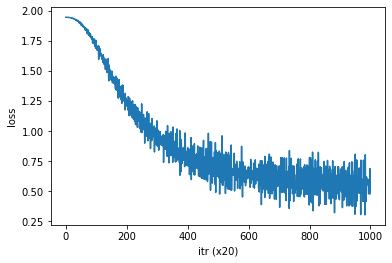

In [15]:
trainer.fit(contexts, target, max_epoch, batch_size, epoch_print=100)
trainer.plot()

In [17]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.0375154 -1.0543264  1.0705326 -1.1086332 -1.3295088]
say [-1.2020301   1.2029941  -1.1917744   0.2952794  -0.07015015]
goodbye [ 0.784661   -0.7455817   0.71045715 -0.9105896  -0.58333874]
and [-0.9299058  0.9161587 -0.9563125  1.5156075 -1.659886 ]
i [ 0.7587031  -0.7464679   0.70633996 -0.8853117  -0.5536923 ]
hello [ 1.0438142 -1.0496376  1.0939697 -1.1020882 -1.3499377]
. [-1.0894954  1.0917407 -1.103228  -1.5821576  1.3693887]


## Simple skip-gram

- skip-gram :  CBOW 모델과 다르게 target으로 부터 주변 맥락(context)를 추측하는 모델
<br/> <img src='../figs/fig%203-23.png'> <br/>
- CBOW보다 더 어려운 문제를 해결하는 것이기 때문에 계산비용은 더 들어가지만 일반적으로 더 좋은 결과를 보임

In [34]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # initialize weight
        W_in = 0.01 * np.random.randn(V, H).astype('f') 
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # layer 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()
        
        #list에 모으기
        layers = [self.in_layer, self.out_layer, self.loss_layer1, self.loss_layer2]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 단어의 분산표현 저장
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        score = self.out_layer.forward(h)
        loss = self.loss_layer1.forward(score, contexts[:, 0]) + self.loss_layer2.forward(score, contexts[:, 1])
        return loss
    
    def backward(self, dout=1):
        dscore = self.loss_layer1.backward(dout) + self.loss_layer2.backward(dout)
        dh = self.out_layer.backward(dscore)
        self.in_layer.backward(dh)
        return None

### 학습

| current_epoch 1 |  itr 1/43 | time 0.0015163421630859375[s] | loss 8.885361660098003
| current_epoch 1 |  itr 21/43 | time 0.02455878257751465[s] | loss 8.885286513962454
| current_epoch 1 |  itr 41/43 | time 0.04071211814880371[s] | loss 8.885236261253045
| current_epoch 2 |  itr 1/43 | time 0.04469704627990723[s] | loss 8.884941428027576
| current_epoch 2 |  itr 21/43 | time 0.06667184829711914[s] | loss 8.884585100767415
| current_epoch 2 |  itr 41/43 | time 0.08273172378540039[s] | loss 8.884406626708307
| current_epoch 3 |  itr 1/43 | time 0.08874964714050293[s] | loss 8.884095403539332
| current_epoch 3 |  itr 21/43 | time 0.10072207450866699[s] | loss 8.883144620587029
| current_epoch 3 |  itr 41/43 | time 0.11388611793518066[s] | loss 8.882055881523517
| current_epoch 4 |  itr 1/43 | time 0.1179814338684082[s] | loss 8.882309331437739
| current_epoch 4 |  itr 21/43 | time 0.13137459754943848[s] | loss 8.878821014441602
| current_epoch 4 |  itr 41/43 | time 0.14301371574401855

| current_epoch 36 |  itr 41/43 | time 1.3936402797698975[s] | loss 7.488890813421348
| current_epoch 37 |  itr 1/43 | time 1.3996241092681885[s] | loss 7.658315267681295
| current_epoch 37 |  itr 21/43 | time 1.4177563190460205[s] | loss 7.451013091924956
| current_epoch 37 |  itr 41/43 | time 1.4317817687988281[s] | loss 7.430954583708106
| current_epoch 38 |  itr 1/43 | time 1.4357798099517822[s] | loss 7.36653695368156
| current_epoch 38 |  itr 21/43 | time 1.4486265182495117[s] | loss 7.3666218265654795
| current_epoch 38 |  itr 41/43 | time 1.4626946449279785[s] | loss 7.395510422828451
| current_epoch 39 |  itr 1/43 | time 1.4657981395721436[s] | loss 7.520208708591793
| current_epoch 39 |  itr 21/43 | time 1.4816513061523438[s] | loss 7.2228988520804
| current_epoch 39 |  itr 41/43 | time 1.4959173202514648[s] | loss 7.3981714123617035
| current_epoch 40 |  itr 1/43 | time 1.4991834163665771[s] | loss 7.270230494969712
| current_epoch 40 |  itr 21/43 | time 1.5130789279937744[s

| current_epoch 70 |  itr 1/43 | time 2.800727367401123[s] | loss 6.831318546131698
| current_epoch 70 |  itr 21/43 | time 2.8166511058807373[s] | loss 5.9168996155381155
| current_epoch 70 |  itr 41/43 | time 2.838883638381958[s] | loss 6.180367565307364
| current_epoch 71 |  itr 1/43 | time 2.8419337272644043[s] | loss 7.03032154398142
| current_epoch 71 |  itr 21/43 | time 2.8580803871154785[s] | loss 5.758302860937302
| current_epoch 71 |  itr 41/43 | time 2.871999979019165[s] | loss 6.419586929624536
| current_epoch 72 |  itr 1/43 | time 2.8749921321868896[s] | loss 5.46058019149108
| current_epoch 72 |  itr 21/43 | time 2.88822340965271[s] | loss 6.059842975264717
| current_epoch 72 |  itr 41/43 | time 2.905858039855957[s] | loss 6.134532594537663
| current_epoch 73 |  itr 1/43 | time 2.9088075160980225[s] | loss 6.67918123880704
| current_epoch 73 |  itr 21/43 | time 2.924769163131714[s] | loss 5.965611876837691
| current_epoch 73 |  itr 41/43 | time 2.938732147216797[s] | loss 

| current_epoch 104 |  itr 41/43 | time 4.573314905166626[s] | loss 5.33487504840984
| current_epoch 105 |  itr 1/43 | time 4.581707715988159[s] | loss 5.67281459111076
| current_epoch 105 |  itr 21/43 | time 4.603160381317139[s] | loss 5.549958223717229
| current_epoch 105 |  itr 41/43 | time 4.622103691101074[s] | loss 5.103994551214412
| current_epoch 106 |  itr 1/43 | time 4.6261396408081055[s] | loss 5.378957191562136
| current_epoch 106 |  itr 21/43 | time 4.6451332569122314[s] | loss 5.517893036297554
| current_epoch 106 |  itr 41/43 | time 4.661134719848633[s] | loss 5.165423513330642
| current_epoch 107 |  itr 1/43 | time 4.665083169937134[s] | loss 5.655097776479251
| current_epoch 107 |  itr 21/43 | time 4.682676315307617[s] | loss 5.331905876560716
| current_epoch 107 |  itr 41/43 | time 4.7059149742126465[s] | loss 5.257621177828013
| current_epoch 108 |  itr 1/43 | time 4.710197687149048[s] | loss 5.507043350807053
| current_epoch 108 |  itr 21/43 | time 4.729962587356567

| current_epoch 137 |  itr 21/43 | time 6.396902799606323[s] | loss 5.260462917168914
| current_epoch 137 |  itr 41/43 | time 6.411218643188477[s] | loss 4.590526073690894
| current_epoch 138 |  itr 1/43 | time 6.414726495742798[s] | loss 4.674635220858403
| current_epoch 138 |  itr 21/43 | time 6.433644771575928[s] | loss 4.90917177895951
| current_epoch 138 |  itr 41/43 | time 6.449604511260986[s] | loss 4.894667000344885
| current_epoch 139 |  itr 1/43 | time 6.453689336776733[s] | loss 5.45269473373251
| current_epoch 139 |  itr 21/43 | time 6.471635580062866[s] | loss 4.792661892849852
| current_epoch 139 |  itr 41/43 | time 6.489927530288696[s] | loss 4.813886308143261
| current_epoch 140 |  itr 1/43 | time 6.49586296081543[s] | loss 5.2642703848012955
| current_epoch 140 |  itr 21/43 | time 6.511796712875366[s] | loss 4.912985368491859
| current_epoch 140 |  itr 41/43 | time 6.530925035476685[s] | loss 4.783348831553336
| current_epoch 141 |  itr 1/43 | time 6.535693168640137[s]

| current_epoch 170 |  itr 21/43 | time 7.911212205886841[s] | loss 4.6182502117246855
| current_epoch 170 |  itr 41/43 | time 7.929677486419678[s] | loss 4.4046310516304255
| current_epoch 171 |  itr 1/43 | time 7.931747198104858[s] | loss 4.967571740168829
| current_epoch 171 |  itr 21/43 | time 7.947755575180054[s] | loss 4.54623615517542
| current_epoch 171 |  itr 41/43 | time 7.96306586265564[s] | loss 4.519149023259161
| current_epoch 172 |  itr 1/43 | time 7.966706991195679[s] | loss 4.824160859872047
| current_epoch 172 |  itr 21/43 | time 7.98431921005249[s] | loss 4.506988092848429
| current_epoch 172 |  itr 41/43 | time 7.997825622558594[s] | loss 4.3216561951375985
| current_epoch 173 |  itr 1/43 | time 8.001749992370605[s] | loss 5.407497727884622
| current_epoch 173 |  itr 21/43 | time 8.01774787902832[s] | loss 4.237332792144523
| current_epoch 173 |  itr 41/43 | time 8.035907983779907[s] | loss 4.687274016565498
| current_epoch 174 |  itr 1/43 | time 8.043562650680542[s

| current_epoch 205 |  itr 21/43 | time 9.702872037887573[s] | loss 4.334965264292197
| current_epoch 205 |  itr 41/43 | time 9.730963945388794[s] | loss 4.133747509858042
| current_epoch 206 |  itr 1/43 | time 9.738942623138428[s] | loss 4.937563724778797
| current_epoch 206 |  itr 21/43 | time 9.760061502456665[s] | loss 4.24021131656106
| current_epoch 206 |  itr 41/43 | time 9.78207802772522[s] | loss 4.1022258235901905
| current_epoch 207 |  itr 1/43 | time 9.790055990219116[s] | loss 3.981876569909364
| current_epoch 207 |  itr 21/43 | time 9.812830924987793[s] | loss 4.236003674246978
| current_epoch 207 |  itr 41/43 | time 9.830986499786377[s] | loss 4.26622258962747
| current_epoch 208 |  itr 1/43 | time 9.835173845291138[s] | loss 4.384849410757172
| current_epoch 208 |  itr 21/43 | time 9.859477043151855[s] | loss 3.9071210629712483
| current_epoch 208 |  itr 41/43 | time 9.87656021118164[s] | loss 4.557390175984958
| current_epoch 209 |  itr 1/43 | time 9.880483627319336[s]

| current_epoch 238 |  itr 41/43 | time 11.262718439102173[s] | loss 3.8578197827265597
| current_epoch 239 |  itr 1/43 | time 11.27269196510315[s] | loss 4.65145401842119
| current_epoch 239 |  itr 21/43 | time 11.293635845184326[s] | loss 3.931157275785344
| current_epoch 239 |  itr 41/43 | time 11.311206340789795[s] | loss 3.97033048227721
| current_epoch 240 |  itr 1/43 | time 11.3152494430542[s] | loss 4.181259171450615
| current_epoch 240 |  itr 21/43 | time 11.329716205596924[s] | loss 4.095929215006312
| current_epoch 240 |  itr 41/43 | time 11.34719967842102[s] | loss 3.9631567760170534
| current_epoch 241 |  itr 1/43 | time 11.350069999694824[s] | loss 3.458973743554555
| current_epoch 241 |  itr 21/43 | time 11.367095947265625[s] | loss 4.042559821152841
| current_epoch 241 |  itr 41/43 | time 11.384095191955566[s] | loss 3.851285312280653
| current_epoch 242 |  itr 1/43 | time 11.391079902648926[s] | loss 4.538130231954024
| current_epoch 242 |  itr 21/43 | time 11.40910887

| current_epoch 274 |  itr 41/43 | time 12.857626676559448[s] | loss 3.815913511668363
| current_epoch 275 |  itr 1/43 | time 12.863085269927979[s] | loss 3.4807046900277787
| current_epoch 275 |  itr 21/43 | time 12.880949974060059[s] | loss 3.7666699925353675
| current_epoch 275 |  itr 41/43 | time 12.894694328308105[s] | loss 3.8813682161528624
| current_epoch 276 |  itr 1/43 | time 12.89775276184082[s] | loss 3.782543144834943
| current_epoch 276 |  itr 21/43 | time 12.915745735168457[s] | loss 3.916016973640904
| current_epoch 276 |  itr 41/43 | time 12.932927370071411[s] | loss 3.662831398770578
| current_epoch 277 |  itr 1/43 | time 12.937894582748413[s] | loss 3.511256639743445
| current_epoch 277 |  itr 21/43 | time 12.955459117889404[s] | loss 3.916496466258254
| current_epoch 277 |  itr 41/43 | time 12.975265979766846[s] | loss 3.6564033576357553
| current_epoch 278 |  itr 1/43 | time 12.978702306747437[s] | loss 3.6113641674371966
| current_epoch 278 |  itr 21/43 | time 12.

| current_epoch 309 |  itr 21/43 | time 14.41500735282898[s] | loss 3.522914945062225
| current_epoch 309 |  itr 41/43 | time 14.44675064086914[s] | loss 3.706469707213482
| current_epoch 310 |  itr 1/43 | time 14.452685117721558[s] | loss 3.3696139291764404
| current_epoch 310 |  itr 21/43 | time 14.4676353931427[s] | loss 3.89854935543473
| current_epoch 310 |  itr 41/43 | time 14.486584424972534[s] | loss 3.435857864033708
| current_epoch 311 |  itr 1/43 | time 14.49156928062439[s] | loss 2.86848359001733
| current_epoch 311 |  itr 21/43 | time 14.513826370239258[s] | loss 3.4453929486390464
| current_epoch 311 |  itr 41/43 | time 14.541794538497925[s] | loss 3.696100408466399
| current_epoch 312 |  itr 1/43 | time 14.544795274734497[s] | loss 3.763490592549953
| current_epoch 312 |  itr 21/43 | time 14.557757377624512[s] | loss 3.6548242122970587
| current_epoch 312 |  itr 41/43 | time 14.569724321365356[s] | loss 3.6560750119026864
| current_epoch 313 |  itr 1/43 | time 14.5732860

| current_epoch 342 |  itr 21/43 | time 16.01368737220764[s] | loss 3.5586685196553987
| current_epoch 342 |  itr 41/43 | time 16.03271770477295[s] | loss 3.474765180355157
| current_epoch 343 |  itr 1/43 | time 16.036891222000122[s] | loss 3.2595868045061973
| current_epoch 343 |  itr 21/43 | time 16.048449277877808[s] | loss 3.544041845357898
| current_epoch 343 |  itr 41/43 | time 16.0678927898407[s] | loss 3.4701001813436116
| current_epoch 344 |  itr 1/43 | time 16.07296848297119[s] | loss 2.827483245259163
| current_epoch 344 |  itr 21/43 | time 16.09068536758423[s] | loss 3.2089176499155143
| current_epoch 344 |  itr 41/43 | time 16.107624530792236[s] | loss 3.781157471415341
| current_epoch 345 |  itr 1/43 | time 16.111790657043457[s] | loss 4.120498659800387
| current_epoch 345 |  itr 21/43 | time 16.130304098129272[s] | loss 3.5639743842135148
| current_epoch 345 |  itr 41/43 | time 16.149474382400513[s] | loss 3.425621748234397
| current_epoch 346 |  itr 1/43 | time 16.15446

| current_epoch 376 |  itr 41/43 | time 17.587790727615356[s] | loss 3.4979888869706235
| current_epoch 377 |  itr 1/43 | time 17.594900369644165[s] | loss 3.646916970122986
| current_epoch 377 |  itr 21/43 | time 17.62880778312683[s] | loss 3.562710701127132
| current_epoch 377 |  itr 41/43 | time 17.65485978126526[s] | loss 3.1493639724249767
| current_epoch 378 |  itr 1/43 | time 17.66081976890564[s] | loss 3.024007111471922
| current_epoch 378 |  itr 21/43 | time 17.687050104141235[s] | loss 3.507155272688832
| current_epoch 378 |  itr 41/43 | time 17.717638969421387[s] | loss 3.1459656350302843
| current_epoch 379 |  itr 1/43 | time 17.72171187400818[s] | loss 3.5820949769224
| current_epoch 379 |  itr 21/43 | time 17.750122547149658[s] | loss 3.4666453219139712
| current_epoch 379 |  itr 41/43 | time 17.77414584159851[s] | loss 3.180235905082786
| current_epoch 380 |  itr 1/43 | time 17.78264880180359[s] | loss 3.2726396435355873
| current_epoch 380 |  itr 21/43 | time 17.8085396

| current_epoch 412 |  itr 41/43 | time 19.33170986175537[s] | loss 3.352324484268962
| current_epoch 413 |  itr 1/43 | time 19.336703062057495[s] | loss 3.713872377887436
| current_epoch 413 |  itr 21/43 | time 19.352190256118774[s] | loss 3.081353956855203
| current_epoch 413 |  itr 41/43 | time 19.368687629699707[s] | loss 3.3231212751440586
| current_epoch 414 |  itr 1/43 | time 19.374667167663574[s] | loss 3.436790107780492
| current_epoch 414 |  itr 21/43 | time 19.394611120224[s] | loss 3.229010155391188
| current_epoch 414 |  itr 41/43 | time 19.416096687316895[s] | loss 3.262433022783695
| current_epoch 415 |  itr 1/43 | time 19.42162561416626[s] | loss 3.3205637696195502
| current_epoch 415 |  itr 21/43 | time 19.435566663742065[s] | loss 3.1073134248533743
| current_epoch 415 |  itr 41/43 | time 19.45369863510132[s] | loss 3.3564668076410102
| current_epoch 416 |  itr 1/43 | time 19.45869278907776[s] | loss 3.070508514197206
| current_epoch 416 |  itr 21/43 | time 19.4736497

| current_epoch 446 |  itr 1/43 | time 20.69890260696411[s] | loss 3.809622389036712
| current_epoch 446 |  itr 21/43 | time 20.71504282951355[s] | loss 2.878746820700864
| current_epoch 446 |  itr 41/43 | time 20.729957818984985[s] | loss 3.485579522857454
| current_epoch 447 |  itr 1/43 | time 20.732913970947266[s] | loss 3.5369065861538735
| current_epoch 447 |  itr 21/43 | time 20.74903130531311[s] | loss 3.2560852109248657
| current_epoch 447 |  itr 41/43 | time 20.763864755630493[s] | loss 3.077288096922513
| current_epoch 448 |  itr 1/43 | time 20.767909288406372[s] | loss 2.826876108020993
| current_epoch 448 |  itr 21/43 | time 20.78483557701111[s] | loss 3.3908731195422233
| current_epoch 448 |  itr 41/43 | time 20.80590558052063[s] | loss 3.04484926664861
| current_epoch 449 |  itr 1/43 | time 20.81189727783203[s] | loss 3.903406770953641
| current_epoch 449 |  itr 21/43 | time 20.829829692840576[s] | loss 3.2556633696109083
| current_epoch 449 |  itr 41/43 | time 20.8457922

| current_epoch 479 |  itr 21/43 | time 22.059184551239014[s] | loss 3.1367410574606054
| current_epoch 479 |  itr 41/43 | time 22.07508158683777[s] | loss 3.174632686984287
| current_epoch 480 |  itr 1/43 | time 22.079076528549194[s] | loss 2.766511718235419
| current_epoch 480 |  itr 21/43 | time 22.101675510406494[s] | loss 3.1589633367136125
| current_epoch 480 |  itr 41/43 | time 22.1319100856781[s] | loss 2.9698811073058375
| current_epoch 481 |  itr 1/43 | time 22.13885807991028[s] | loss 3.862302258365648
| current_epoch 481 |  itr 21/43 | time 22.16588544845581[s] | loss 3.0661146243526245
| current_epoch 481 |  itr 41/43 | time 22.194005727767944[s] | loss 3.0922369049300302
| current_epoch 482 |  itr 1/43 | time 22.198004961013794[s] | loss 2.9941328244396126
| current_epoch 482 |  itr 21/43 | time 22.22280764579773[s] | loss 3.2605365184742565
| current_epoch 482 |  itr 41/43 | time 22.243788719177246[s] | loss 3.0058371232804992
| current_epoch 483 |  itr 1/43 | time 22.25

| current_epoch 513 |  itr 21/43 | time 23.436946868896484[s] | loss 3.132121637968967
| current_epoch 513 |  itr 41/43 | time 23.451910734176636[s] | loss 2.983708548452801
| current_epoch 514 |  itr 1/43 | time 23.45690894126892[s] | loss 3.170777241974999
| current_epoch 514 |  itr 21/43 | time 23.46842861175537[s] | loss 3.1892907865013784
| current_epoch 514 |  itr 41/43 | time 23.481382608413696[s] | loss 2.9755385749124033
| current_epoch 515 |  itr 1/43 | time 23.48440384864807[s] | loss 3.4237731048164726
| current_epoch 515 |  itr 21/43 | time 23.497986555099487[s] | loss 2.9336367592963355
| current_epoch 515 |  itr 41/43 | time 23.511643886566162[s] | loss 3.1430440639322446
| current_epoch 516 |  itr 1/43 | time 23.515739917755127[s] | loss 3.104318877102346
| current_epoch 516 |  itr 21/43 | time 23.528717517852783[s] | loss 3.4378839782336628
| current_epoch 516 |  itr 41/43 | time 23.540855407714844[s] | loss 2.8046205260933896
| current_epoch 517 |  itr 1/43 | time 23.

| current_epoch 547 |  itr 41/43 | time 25.095975637435913[s] | loss 2.9870938947388725
| current_epoch 548 |  itr 1/43 | time 25.09800887107849[s] | loss 3.3896216104802743
| current_epoch 548 |  itr 21/43 | time 25.10993719100952[s] | loss 2.990474458901683
| current_epoch 548 |  itr 41/43 | time 25.122981309890747[s] | loss 3.0630421845853104
| current_epoch 549 |  itr 1/43 | time 25.124974489212036[s] | loss 2.443827108236484
| current_epoch 549 |  itr 21/43 | time 25.133604764938354[s] | loss 2.8696427585507527
| current_epoch 549 |  itr 41/43 | time 25.14814567565918[s] | loss 3.080290537527997
| current_epoch 550 |  itr 1/43 | time 25.151137590408325[s] | loss 3.6543883983827037
| current_epoch 550 |  itr 21/43 | time 25.162107229232788[s] | loss 3.066090275864153
| current_epoch 550 |  itr 41/43 | time 25.171091556549072[s] | loss 2.8865152128640186
| current_epoch 551 |  itr 1/43 | time 25.173086404800415[s] | loss 3.854389647985027
| current_epoch 551 |  itr 21/43 | time 25.1

| current_epoch 579 |  itr 21/43 | time 26.309651851654053[s] | loss 2.69986249968946
| current_epoch 579 |  itr 41/43 | time 26.32371473312378[s] | loss 3.319870339257862
| current_epoch 580 |  itr 1/43 | time 26.326746225357056[s] | loss 2.635824860902609
| current_epoch 580 |  itr 21/43 | time 26.338674783706665[s] | loss 2.7088016382561184
| current_epoch 580 |  itr 41/43 | time 26.350682735443115[s] | loss 3.1197612329639446
| current_epoch 581 |  itr 1/43 | time 26.3546781539917[s] | loss 3.6507002727663895
| current_epoch 581 |  itr 21/43 | time 26.366657495498657[s] | loss 2.862200740671679
| current_epoch 581 |  itr 41/43 | time 26.380725860595703[s] | loss 3.2817498609977362
| current_epoch 582 |  itr 1/43 | time 26.385815858840942[s] | loss 2.5187087815259663
| current_epoch 582 |  itr 21/43 | time 26.4097683429718[s] | loss 3.1015709797668842
| current_epoch 582 |  itr 41/43 | time 26.437825441360474[s] | loss 2.707233940700821
| current_epoch 583 |  itr 1/43 | time 26.4438

| current_epoch 612 |  itr 21/43 | time 27.695669889450073[s] | loss 3.0393531671458685
| current_epoch 612 |  itr 41/43 | time 27.726675271987915[s] | loss 2.8818886447314016
| current_epoch 613 |  itr 1/43 | time 27.731770992279053[s] | loss 3.0007145990739104
| current_epoch 613 |  itr 21/43 | time 27.75560712814331[s] | loss 2.884161830484646
| current_epoch 613 |  itr 41/43 | time 27.781813621520996[s] | loss 2.9214218122384983
| current_epoch 614 |  itr 1/43 | time 27.788789987564087[s] | loss 3.5198398576866587
| current_epoch 614 |  itr 21/43 | time 27.812904834747314[s] | loss 2.96572247792507
| current_epoch 614 |  itr 41/43 | time 27.836798429489136[s] | loss 2.962158264779295
| current_epoch 615 |  itr 1/43 | time 27.84182119369507[s] | loss 2.6982660677698953
| current_epoch 615 |  itr 21/43 | time 27.86810278892517[s] | loss 3.0933310236846294
| current_epoch 615 |  itr 41/43 | time 27.88803505897522[s] | loss 2.584034660736588
| current_epoch 616 |  itr 1/43 | time 27.89

| current_epoch 646 |  itr 1/43 | time 29.24475336074829[s] | loss 3.090783086423859
| current_epoch 646 |  itr 21/43 | time 29.281615734100342[s] | loss 3.042314210710478
| current_epoch 646 |  itr 41/43 | time 29.311777591705322[s] | loss 2.8900243200201556
| current_epoch 647 |  itr 1/43 | time 29.3166983127594[s] | loss 2.4374806396881348
| current_epoch 647 |  itr 21/43 | time 29.35272789001465[s] | loss 2.9390947711401387
| current_epoch 647 |  itr 41/43 | time 29.38288450241089[s] | loss 2.8397271697752444
| current_epoch 648 |  itr 1/43 | time 29.390860080718994[s] | loss 2.5896901100359364
| current_epoch 648 |  itr 21/43 | time 29.40715718269348[s] | loss 2.884135012757978
| current_epoch 648 |  itr 41/43 | time 29.417762756347656[s] | loss 3.018750835008188
| current_epoch 649 |  itr 1/43 | time 29.419752836227417[s] | loss 2.7430397869714462
| current_epoch 649 |  itr 21/43 | time 29.43172550201416[s] | loss 2.896975983156187
| current_epoch 649 |  itr 41/43 | time 29.44208

| current_epoch 680 |  itr 41/43 | time 30.914328813552856[s] | loss 2.779445318048541
| current_epoch 681 |  itr 1/43 | time 30.920214891433716[s] | loss 4.262985049962825
| current_epoch 681 |  itr 21/43 | time 30.94657874107361[s] | loss 2.99532379358127
| current_epoch 681 |  itr 41/43 | time 30.97615647315979[s] | loss 2.780253236679144
| current_epoch 682 |  itr 1/43 | time 30.983067512512207[s] | loss 2.9795668681616356
| current_epoch 682 |  itr 21/43 | time 31.00717830657959[s] | loss 2.8353837397951223
| current_epoch 682 |  itr 41/43 | time 31.03183150291443[s] | loss 2.804310890649399
| current_epoch 683 |  itr 1/43 | time 31.037832260131836[s] | loss 3.536190075169974
| current_epoch 683 |  itr 21/43 | time 31.058834314346313[s] | loss 2.826426704309751
| current_epoch 683 |  itr 41/43 | time 31.080721855163574[s] | loss 2.9479804202869
| current_epoch 684 |  itr 1/43 | time 31.08670735359192[s] | loss 3.5873816679492605
| current_epoch 684 |  itr 21/43 | time 31.108850955

| current_epoch 714 |  itr 21/43 | time 32.92299747467041[s] | loss 3.1494975307009296
| current_epoch 714 |  itr 41/43 | time 32.938005208969116[s] | loss 2.673596296795946
| current_epoch 715 |  itr 1/43 | time 32.94094204902649[s] | loss 3.033796278176357
| current_epoch 715 |  itr 21/43 | time 32.95490121841431[s] | loss 2.7930292641786068
| current_epoch 715 |  itr 41/43 | time 32.96808052062988[s] | loss 2.970502417631148
| current_epoch 716 |  itr 1/43 | time 32.9710009098053[s] | loss 2.2631606975491354
| current_epoch 716 |  itr 21/43 | time 32.989025354385376[s] | loss 3.192005884442494
| current_epoch 716 |  itr 41/43 | time 33.00066041946411[s] | loss 2.744594484938013
| current_epoch 717 |  itr 1/43 | time 33.005595684051514[s] | loss 1.7207599090467394
| current_epoch 717 |  itr 21/43 | time 33.016127824783325[s] | loss 2.856049815342131
| current_epoch 717 |  itr 41/43 | time 33.02842903137207[s] | loss 2.8119304367621116
| current_epoch 718 |  itr 1/43 | time 33.0331370

| current_epoch 749 |  itr 21/43 | time 34.53713369369507[s] | loss 2.8246263193946954
| current_epoch 749 |  itr 41/43 | time 34.5562059879303[s] | loss 2.7616847726739704
| current_epoch 750 |  itr 1/43 | time 34.56119227409363[s] | loss 2.9548932625509146
| current_epoch 750 |  itr 21/43 | time 34.58464050292969[s] | loss 2.6658887196133536
| current_epoch 750 |  itr 41/43 | time 34.607699394226074[s] | loss 3.0776599137634872
| current_epoch 751 |  itr 1/43 | time 34.613627910614014[s] | loss 2.808376480898035
| current_epoch 751 |  itr 21/43 | time 34.63471984863281[s] | loss 2.827822978807893
| current_epoch 751 |  itr 41/43 | time 34.65962076187134[s] | loss 2.9107120208779578
| current_epoch 752 |  itr 1/43 | time 34.66360926628113[s] | loss 2.749934162351438
| current_epoch 752 |  itr 21/43 | time 34.685035943984985[s] | loss 2.4857157101485337
| current_epoch 752 |  itr 41/43 | time 34.704131841659546[s] | loss 3.160830143554939
| current_epoch 753 |  itr 1/43 | time 34.70812

| current_epoch 781 |  itr 21/43 | time 36.182101249694824[s] | loss 2.686735498936766
| current_epoch 781 |  itr 41/43 | time 36.20997643470764[s] | loss 3.012849527340788
| current_epoch 782 |  itr 1/43 | time 36.21791124343872[s] | loss 2.6377983946107215
| current_epoch 782 |  itr 21/43 | time 36.239447593688965[s] | loss 2.784184381063643
| current_epoch 782 |  itr 41/43 | time 36.25787401199341[s] | loss 2.837142202784662
| current_epoch 783 |  itr 1/43 | time 36.26277184486389[s] | loss 2.9905972163318704
| current_epoch 783 |  itr 21/43 | time 36.283785820007324[s] | loss 2.8630255402870235
| current_epoch 783 |  itr 41/43 | time 36.30764627456665[s] | loss 2.8036836810869046
| current_epoch 784 |  itr 1/43 | time 36.311638593673706[s] | loss 2.823856342693352
| current_epoch 784 |  itr 21/43 | time 36.33557438850403[s] | loss 3.2208984902015088
| current_epoch 784 |  itr 41/43 | time 36.35663461685181[s] | loss 2.564577606910409
| current_epoch 785 |  itr 1/43 | time 36.362671

| current_epoch 815 |  itr 21/43 | time 38.02408742904663[s] | loss 2.467316308808738
| current_epoch 815 |  itr 41/43 | time 38.05271029472351[s] | loss 3.3395921697198334
| current_epoch 816 |  itr 1/43 | time 38.0596866607666[s] | loss 1.4433670749819865
| current_epoch 816 |  itr 21/43 | time 38.080806732177734[s] | loss 2.6917319104220194
| current_epoch 816 |  itr 41/43 | time 38.10648798942566[s] | loss 3.008428254137622
| current_epoch 817 |  itr 1/43 | time 38.11233162879944[s] | loss 2.465405954640252
| current_epoch 817 |  itr 21/43 | time 38.13032627105713[s] | loss 2.9167842015166014
| current_epoch 817 |  itr 41/43 | time 38.149656772613525[s] | loss 2.904185286147576
| current_epoch 818 |  itr 1/43 | time 38.154646158218384[s] | loss 2.107442656533029
| current_epoch 818 |  itr 21/43 | time 38.17782807350159[s] | loss 2.669764269848592
| current_epoch 818 |  itr 41/43 | time 38.19731378555298[s] | loss 3.0097717415769645
| current_epoch 819 |  itr 1/43 | time 38.20731019

| current_epoch 848 |  itr 41/43 | time 39.68498659133911[s] | loss 2.9741389067890807
| current_epoch 849 |  itr 1/43 | time 39.6934015750885[s] | loss 2.6440994507186732
| current_epoch 849 |  itr 21/43 | time 39.718907594680786[s] | loss 2.7855563930061953
| current_epoch 849 |  itr 41/43 | time 39.748706102371216[s] | loss 3.0128162578352162
| current_epoch 850 |  itr 1/43 | time 39.75169801712036[s] | loss 2.032159205085112
| current_epoch 850 |  itr 21/43 | time 39.76815867424011[s] | loss 2.957470225785057
| current_epoch 850 |  itr 41/43 | time 39.788111209869385[s] | loss 2.6873686220434814
| current_epoch 851 |  itr 1/43 | time 39.79373741149902[s] | loss 2.3563355452010137
| current_epoch 851 |  itr 21/43 | time 39.812687397003174[s] | loss 2.660938385282998
| current_epoch 851 |  itr 41/43 | time 39.83135223388672[s] | loss 2.9913417765431722
| current_epoch 852 |  itr 1/43 | time 39.83561134338379[s] | loss 2.2673281522220368
| current_epoch 852 |  itr 21/43 | time 39.8569

| current_epoch 885 |  itr 41/43 | time 41.46464705467224[s] | loss 2.9854983594666185
| current_epoch 886 |  itr 1/43 | time 41.471630334854126[s] | loss 3.090653050254165
| current_epoch 886 |  itr 21/43 | time 41.49076557159424[s] | loss 2.618207641684543
| current_epoch 886 |  itr 41/43 | time 41.511780738830566[s] | loss 2.9040945587373317
| current_epoch 887 |  itr 1/43 | time 41.51589226722717[s] | loss 3.26657914035327
| current_epoch 887 |  itr 21/43 | time 41.534719944000244[s] | loss 2.683435065720074
| current_epoch 887 |  itr 41/43 | time 41.554683446884155[s] | loss 2.854387124209139
| current_epoch 888 |  itr 1/43 | time 41.55967712402344[s] | loss 3.5650434172598913
| current_epoch 888 |  itr 21/43 | time 41.58563852310181[s] | loss 2.7974280745795554
| current_epoch 888 |  itr 41/43 | time 41.608747482299805[s] | loss 2.8122586994548104
| current_epoch 889 |  itr 1/43 | time 41.61572504043579[s] | loss 2.118477661403849
| current_epoch 889 |  itr 21/43 | time 41.637034

| current_epoch 918 |  itr 1/43 | time 43.08739900588989[s] | loss 2.8269506370112403
| current_epoch 918 |  itr 21/43 | time 43.1069860458374[s] | loss 2.4820635191059566
| current_epoch 918 |  itr 41/43 | time 43.12472677230835[s] | loss 3.0758928023497316
| current_epoch 919 |  itr 1/43 | time 43.13075113296509[s] | loss 1.856430275353036
| current_epoch 919 |  itr 21/43 | time 43.15076780319214[s] | loss 2.6536779446004264
| current_epoch 919 |  itr 41/43 | time 43.169851779937744[s] | loss 3.023673138181829
| current_epoch 920 |  itr 1/43 | time 43.17487978935242[s] | loss 2.8417957973814545
| current_epoch 920 |  itr 21/43 | time 43.191625118255615[s] | loss 2.984391332074798
| current_epoch 920 |  itr 41/43 | time 43.21346473693848[s] | loss 2.518112971982186
| current_epoch 921 |  itr 1/43 | time 43.21746850013733[s] | loss 2.5841655604927696
| current_epoch 921 |  itr 21/43 | time 43.23695969581604[s] | loss 2.827872593016043
| current_epoch 921 |  itr 41/43 | time 43.25767803

| current_epoch 951 |  itr 41/43 | time 44.688923597335815[s] | loss 2.841952711798373
| current_epoch 952 |  itr 1/43 | time 44.699867248535156[s] | loss 4.224873319074304
| current_epoch 952 |  itr 21/43 | time 44.72972512245178[s] | loss 2.5785678012338797
| current_epoch 952 |  itr 41/43 | time 44.7619469165802[s] | loss 2.948580522881616
| current_epoch 953 |  itr 1/43 | time 44.76824617385864[s] | loss 1.913470171130369
| current_epoch 953 |  itr 21/43 | time 44.80112338066101[s] | loss 2.9888123258263466
| current_epoch 953 |  itr 41/43 | time 44.84608340263367[s] | loss 2.572344515801394
| current_epoch 954 |  itr 1/43 | time 44.85171055793762[s] | loss 3.054269228210319
| current_epoch 954 |  itr 21/43 | time 44.88486886024475[s] | loss 2.6917442997739736
| current_epoch 954 |  itr 41/43 | time 44.91696834564209[s] | loss 2.8855000027945117
| current_epoch 955 |  itr 1/43 | time 44.91978168487549[s] | loss 3.326372105427532
| current_epoch 955 |  itr 21/43 | time 44.9348270893

| current_epoch 985 |  itr 21/43 | time 46.33982849121094[s] | loss 2.6049990041300903
| current_epoch 985 |  itr 41/43 | time 46.3747832775116[s] | loss 2.8374247764821896
| current_epoch 986 |  itr 1/43 | time 46.38073205947876[s] | loss 2.8466443647846833
| current_epoch 986 |  itr 21/43 | time 46.403807640075684[s] | loss 2.9826271675457887
| current_epoch 986 |  itr 41/43 | time 46.42703890800476[s] | loss 2.596970897162187
| current_epoch 987 |  itr 1/43 | time 46.43202304840088[s] | loss 2.753619939311898
| current_epoch 987 |  itr 21/43 | time 46.45176100730896[s] | loss 2.6362064700938395
| current_epoch 987 |  itr 41/43 | time 46.47191262245178[s] | loss 2.7300666402814215
| current_epoch 988 |  itr 1/43 | time 46.478028297424316[s] | loss 3.230163746878502
| current_epoch 988 |  itr 21/43 | time 46.49911570549011[s] | loss 2.907387660359567
| current_epoch 988 |  itr 41/43 | time 46.52187538146973[s] | loss 2.709510560769517
| current_epoch 989 |  itr 1/43 | time 46.52782368

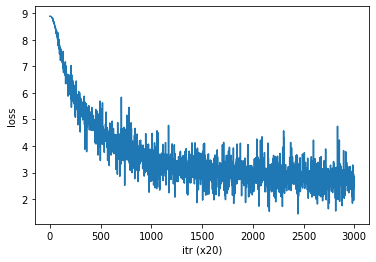

In [35]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'English is a West Germanic language of the Indo-European language family, originally spoken by the inhabitants of early medieval England. It is named after the Angles, one of the ancient Germanic peoples that migrated to the area of Great Britain that later took their name, England. Both names derive from Anglia, a peninsula on the Baltic Sea which is not to be confused with East Anglia, the Eastern part of England which comprises the counties of Norfolk, Suffolk and Essex. English is most closely related to Frisian and Low Saxon, while its vocabulary has been significantly influenced by other Germanic languages, particularly Old Norse (a North Germanic language), as well as by Old Norman, French and Latin.'
corpus, word_to_id, id_to_word = preprocess(text)

#Create context, target
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)

# one-hot encoding
contexts = convert_one_hot(contexts, vocab_size)
target = convert_one_hot(target, vocab_size)

#model 선언
model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()